In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qw.walksystem import WalkSystem
from qw.analysis import transform_counts_list

In [2]:
folder = 'sim'
sys = 'qasm'
network = 'dsg'
walktype = '3tqw'
encoding = 'bin'
order = 2
layers = 10
ws = WalkSystem(folder, sys, network, walktype=walktype, encoding=encoding, order=order, layers=layers)
counts_list = ws.read_counts_list()
counts_list = transform_counts_list(counts_list)

In [3]:
import numpy as np

def DSG_Hamiltonian(order: int=2, gamma: float=1.) -> np.ndarray:
    
    size = 3**order
    A = np.zeros((size, size))
    
    for i in [n+1 for n in range(order)]:
        for j in range(int(size/(3**i))):
            a1 = np.floor((j*9 + 0*3 + 1) * 3**(i-2)).astype(int)
            a2 = np.floor((j*9 + 1*3 + 2) * 3**(i-2)).astype(int)
            b1 = np.floor((j*9 + 1*3 + 1) * 3**(i-2)).astype(int)
            b2 = np.floor((j*9 + 2*3 + 2) * 3**(i-2)).astype(int)
            c1 = np.floor((j*9 + 2*3 + 1) * 3**(i-2)).astype(int)
            c2 = np.floor((j*9 + 0*3 + 2) * 3**(i-2)).astype(int)
            A[a1, a2] = 1
            A[a2, a1] = 1
            A[b1, b2] = 1
            A[b2, b1] = 1
            A[c1, c2] = 1
            A[c2, c1] = 1
    
    for i in range(size):
        A[i, i] = -A.sum(axis=1)[i]
    
    return -gamma*A

In [4]:
from matplotlib.colors import LinearSegmentedColormap

cdict = {'red':   ((0.00, 0.00, 0.00), 
                   (0.20, 0.95, 0.95),
                   (0.40, 0.95, 0.95),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'green': ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.50, 0.50),
                   (0.60, 0.95, 0.95),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.00, 0.00)),

         'blue':  ((0.00, 0.00, 0.00), 
                   (0.20, 0.00, 0.00),
                   (0.40, 0.30, 0.30),
                   (0.60, 0.50, 0.50),
                   (0.80, 0.95, 0.95),
                   (1.00, 0.95, 0.95))
          }

cmap = LinearSegmentedColormap('star', cdict)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_distribution(G, pos, node_size=100, node_color="#1f78b4", alpha=1., mapper=None, 
                      cmap=None, vmin=None, vmax=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=alpha, 
                                   cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    cb = plt.colorbar(mapper, ax=ax, extend='min')
    cb.ax.tick_params(labelsize=12)
    ax.axis('off')
    
    return nodes

In [6]:
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable

G = nx.from_numpy_array(abs(DSG_Hamiltonian(order, 1)))
G.remove_edges_from(nx.selfloop_edges(G))
pos = nx.kamada_kawai_layout(G)

# vmin = 10**(1-order)
vmin = .5*10**(1-order)
vmax = 1.
mapper = ScalarMappable(norm=LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)

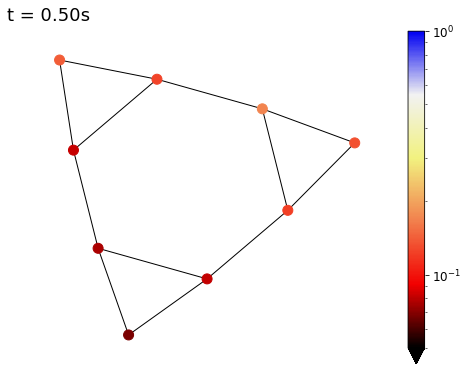

In [7]:
choose = 49
dt = 0.01

dpi = 72
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[choose]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % ((choose+1)*dt), fontsize=18)

plt.show()

In [47]:
from matplotlib import animation

dpi = 300
steps = 300
dt = 0.01
playtime = 15
interval = int(playtime*1000/steps)
fps = int(steps/playtime)
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

node_color = counts_list[0]
time_template = 't = %.2fs'

nodes = draw_distribution(G, pos, ax=ax, node_color=mapper.to_rgba(node_color), mapper=mapper)
time_text = ax.text(-1, 1, time_template % 0., fontsize=18)

def animate(i):
    global nodes, time_text
    nodes.remove()
    time_text.remove()
    node_color = counts_list[i]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=mapper.to_rgba(node_color), alpha=1.)
    time_text = ax.text(-1, 1, time_template % ((i+1)*dt), fontsize=18)
    return 0

ani = animation.FuncAnimation(fig, animate, frames=steps, interval=interval)

def progress_callback(i, n):
    print(f'Saving frame {i} of {n}', end='\r')
    return 0

writer = animation.writers['ffmpeg'](fps=fps)
path = f'videos/{ws.name}_animation.mp4'
ani.save(path, writer=writer, dpi=dpi, progress_callback=progress_callback)
del ani
plt.close(fig)
print(f'Saving frame {steps} of {steps} complete!')

Saving frame 300 of 300 complete!
